### Embedding, and spacial reduction
Do you need all those fancy words? Why say vacuous when you can say dumb? Because it's erudite to do so...

It depends on the degree of fidelity required for the problem at hand. The problem is defined by what is said, but also by whom, and when. At best, we can develop a model for language that is useful. However, no model of language is correct. Just pick a different speaker, perhaps one who uses the word '[nice](https://www.etymonline.com/word/nice#etymonline_v_6918)' in its original meaning.

OK, let's learn something about Carmilla.

In [1]:
# import useful stuff
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
with open('carmilla.txt', 'r') as f:
    corpus = f.read()

In [3]:
from utils.cheaters import dctConstr

dct = dctConstr(stop_words=["i", "you", "a"], ignore_case=True)
dct.constructor(corpus)
# dct.trimmer(top=5, bottom=10)
# dct.build_tfidf(corpus)

def split_by_paragraphs(data:str) -> []:
    processed=data.lower()
    while '\n\n\n' in processed:
        processed=processed.replace('\n\n\n','\n\n')
    out = processed.split('\n\n')
    return [o.replace("\n", " ") for o in out]

pcorp = split_by_paragraphs(corpus)
pbow = [dct(para) for para in pcorp]
ptfidf = [dct.tfidf(para) for para in pcorp]
pvec = [dct.bow_to_vec(p) for p in pbow]

20


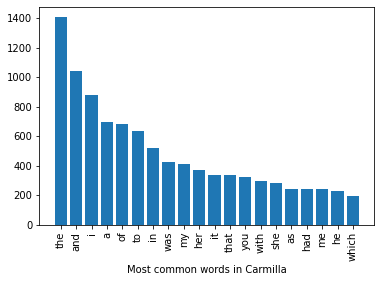

In [4]:
zipf = dct.counts.most_common(20)
z_val = [j for i, j in zipf]
z_term = [i for i, j in zipf]
print(len(zipf))
plt.bar(range(len(zipf)), z_val, align='center')
plt.xticks(range(len(zipf)), z_term, rotation=90)
plt.xlabel("Most common words in Carmilla")
plt.show()

Given that our most popular words are terms such as "it", the value for identifying/separating one document from another is limited. For now, let's leave these stop words in there so that we can see the difference removing them makes later.

### Vector comparison of document
Since we have vector representations of each paragraph, we can now compare the to one another. We can do that by calculating the difference in the distance between then--by completing the triangle. This approach is mathematically simple, but has produces higher scores where terms are repeated. So "it was the best ever" is significantly different than "it was the best best best ever".

Therefor, the common approach is to use the angular difference between the two vectors and ignore the length. The cosine similarity as it is generally known is the normalized dot product of the two.

In [5]:
from sklearn.metrics import pairwise as pair
pcos = pair.cosine_similarity(pvec)
print(np.shape(pcos))

(676, 676)


So now we have matrix where each entry indicates the relationship of that index element to the other index element. For matrix representation as for an array, row number is denoted by the first index and column by the second.

So the cosine between paragraph 10 and paragraph 100 would be denoted by $M_{ij}$ where $i=10$ and $j=100$, which for the array would be $M[10, 100]$. As an exploration, let us find the nearest neighbors of paragraph 140:
```
i don't know which should be most afraid of the other," she said, again smiling--"if you were less pretty i think i should be very much afraid of you, but being as you are, and you and i both so young, i feel only that i have made your acquaintance twelve years ago, and have already a right to your intimacy; at all events it does seem as if we were destined, from our earliest childhood, to be friends. i wonder whether you feel as strangely drawn towards me as i do to you; i have never had a friend--shall i find one now?" she sighed, and her fine dark eyes gazed passionately on me.
```

In [6]:
hundred = pcos[140]
print(pcorp[140])
NN = sorted(enumerate(hundred), key=lambda x:x[1], reverse=True)
print(NN[:5])

"i don't know which should be most afraid of the other," she said, again smiling--"if you were less pretty i think i should be very much afraid of you, but being as you are, and you and i both so young, i feel only that i have made your acquaintance twelve years ago, and have already a right to your intimacy; at all events it does seem as if we were destined, from our earliest childhood, to be friends. i wonder whether you feel as strangely drawn towards me as i do to you; i have never had a friend--shall i find one now?" she sighed, and her fine dark eyes gazed passionately on me.
[(140, 0.9999999999999996), (137, 0.7008612115077368), (293, 0.6859981267346387), (543, 0.6752572778121025), (138, 0.6649559855120479)]


Obviously, paragraph 100 has a perfect similarity of unity with itself. Where vector are most similar, they are closer to unity, at which point they are identical.

Let's have a look at the next closest paragraph.

In [7]:
print(pcorp[137])
print()
print(pcorp[293])

"i must tell you my vision about you; it is so very strange that you and i should have had, each of the other so vivid a dream, that each should have seen, i you and you me, looking as we do now, when of course we both were mere children. i was a child, about six years old, and i awoke from a confused and troubled dream, and found myself in a room, unlike my nursery, wainscoted clumsily in some dark wood, and with cupboards and bedsteads, and chairs, and benches placed about it. the beds were, i thought, all empty, and the room itself without anyone but myself in it; and i, after looking about me for some time, and admiring especially an iron candlestick with two branches, which i should certainly know again, crept under one of the beds to reach the window; but as i got from under the bed, i heard someone crying; and looking up, while i was still upon my knees, i saw you--most assuredly you--as i see you now; a beautiful young lady, with golden hair and large blue eyes, and lips--your 

Similar? It is certainly evident that there are a number of terms in common, but they are definately not identical. Generally, cosine scores greater than 0.7 have a lot in common. Less than 0.7 they are interpreted differently.

### Visualization
The common approach used across many disciplines to represent high-dimensional data in a 2- or 3-D space is principle component analysis. For a detailed disussion of this and latent semantic analysis (LSA) please review this [github](https://github.com/rbnsnsd2/quantitative_stats/blob/master/PCA_LSA.ipynb). The examples are given in R, so you will need to re-evaluate in python.

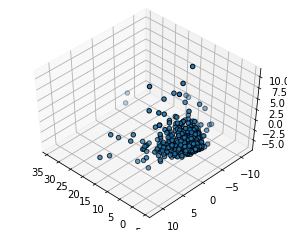

In [8]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition

fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(pvec)
X = pca.transform(pvec)

ax.scatter(X[:, 0], X[:, 1], X[:, 2],
           edgecolor='k')

### Exercise 03
- Find paragraphs with similarity score higher than 0.85
- Construct a 2-D plot with the high similarity score paragraphs highlighted in a different color
- Label the points by paragraph number
- Read the paragraphs that form outliers to determine why they are separate from the body of the corpus
- Read several of the paragraphs along the extremes of one of the axes, describe the similarity/difference along the axis